# CNN-lytical Assignment-2
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   We will be using the same dataset as the previous assignment for MNIST. **Do not** use the complete MNIST dataset, even though PyTorch makes it really easy.

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [31]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
np.random.seed(0)


## Load *Dataset*
Use the pickle file shared for the previous assignment here.

In [32]:
# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/gdrive')

# load the data set
with open('/content/gdrive/My Drive/CNN/asgn_2/train_data.pkl', 'rb') as f:
    data = pickle.load(f)

x_prev = data['X']
y = data['y']

# normalisation
std_vec=np.std(x_prev,axis=0)
std_vec[np.where(std_vec==0)]=1e-22
X=(x_prev-np.mean(x_prev,axis=0))/std_vec

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25)

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


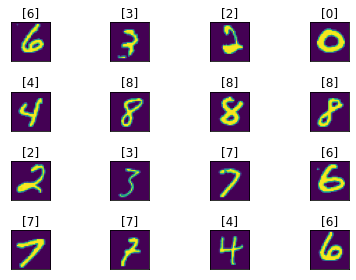

In [33]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels

random_indices = np.random.choice(x_prev.shape[0]-1, size=16, replace=False)
random_images = x_prev[random_indices, :]
random_images_labels = y[random_indices, :]

# Create plt plot:
fig = plt.figure()

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(np.reshape(random_images[i],(28,28)))
  plt.title("{}".format(random_images_labels[i]))
  plt.xticks([])
  plt.yticks([])

fig.tight_layout()


## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


**Note** - Things like normalization, augmentation etc. which are related to the dataset are all done in this class. However, because this assignment doesn't deal with MNIST images but rather feature vectors, this part is being skipped here and will be discussed in Assignment 3.

In [34]:
# define your dataset class
class ImageDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.img_labels = y_data
        self.imgs = X_data

    def __len__(self):
        return len(self.img_labels)
        
    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        return image, label


## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [35]:
import torch.nn as nn 

# define a child class of nn.Module for your model
# specify the architecture here itself

#3 hidden layers  

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
         super(NeuralNet, self).__init__()
         self.input_size = input_size
         self.l1 = nn.Linear(input_size, hidden_size1) 
         self.relu = nn.ReLU()
         self.l2 = nn.Linear(hidden_size1, hidden_size2)
         self.relu = nn.ReLU()
         self.l3 = nn.Linear(hidden_size2, hidden_size3)
         self.relu = nn.ReLU()
         self.l4 = nn.Linear(hidden_size3, num_classes)

    def forward(self, x):
         out = self.l1(x)
         out = self.relu(out)
         out = self.l2(out)
         out = self.relu(out)
         out = self.l3(out)
         out = self.relu(out)
         out = self.l4(out)
         
         # no softmax at the end since already included in cross entropy loss function
         return out




## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [36]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    for i, (images, labels) in enumerate(train_loader):   
         # Forward pass
         outputs = model(images.float())
         labels=torch.flatten(labels)
         loss = criterion(outputs, labels)
         # Backward and optimize
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
    if (display_step==1):
      print("Loss is: ",loss.item())    


## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [37]:
def init_weights(model_instance):
    if isinstance(model_instance, nn.Linear):
        torch.nn.init.xavier_uniform_(model_instance.weight)
        model_instance.bias.data.fill_(0.01)


## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [38]:
def predict(model, X_test):
    outputs=model(X_test.float())
    _, predicted = torch.max(outputs.data, 1)
    return predicted.numpy()

In [39]:
def accuracy(pred, labels):
    frac_correct = np.mean(pred == labels)
    return 100*frac_correct

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [40]:
input_size = 784 
hidden_size1 = 200 
hidden_size2 = 100 
hidden_size3 = 50 
num_classes = 10
num_epochs = 136
batch_size = 64
learning_rate = 0.005 

train_dataset = ImageDataset(X_train,y_train)
test_dataset = ImageDataset(X_test,y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

network=NeuralNet(input_size, hidden_size1, hidden_size2,hidden_size3, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

#initiate
network.apply(init_weights)

for epoch in range(num_epochs):
  print(epoch)
  if (epoch%5==0):
    train(network, optimizer, criterion, train_dataloader, 1)
  else:
    train(network, optimizer, criterion, train_dataloader, 0)    

final_model=network

0
Loss is:  0.2983074188232422
1
2
3
4
5
Loss is:  0.1427004337310791
6
7
8
9
10
Loss is:  0.0457005500793457
11
12
13
14
15
Loss is:  0.053034622222185135
16
17
18
19
20
Loss is:  0.035532739013433456
21
22
23
24
25
Loss is:  0.0012964075431227684
26
27
28
29
30
Loss is:  0.02906898595392704
31
32
33
34
35
Loss is:  0.04847501218318939
36
37
38
39
40
Loss is:  0.0023488060105592012
41
42
43
44
45
Loss is:  0.002826591720804572
46
47
48
49
50
Loss is:  0.012460393831133842
51
52
53
54
55
Loss is:  3.839809141936712e-05
56
57
58
59
60
Loss is:  0.0005841317470185459
61
62
63
64
65
Loss is:  0.006871075369417667
66
67
68
69
70
Loss is:  0.002558971755206585
71
72
73
74
75
Loss is:  0.002104299608618021
76
77
78
79
80
Loss is:  0.03247454762458801
81
82
83
84
85
Loss is:  0.008207790553569794
86
87
88
89
90
Loss is:  4.898573024547659e-05
91
92
93
94
95
Loss is:  0.0042420788668096066
96
97
98
99
100
Loss is:  0.00032205088064074516
101
102
103
104
105
Loss is:  2.0265508737793425e-06
106

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [41]:
with torch.no_grad():
     predicted=predict(final_model,X_train) 
     print(accuracy(predicted,(torch.flatten(y_train)).numpy()))  
     
     predicted=predict(final_model,X_test) 
     print(accuracy(predicted,(torch.flatten(y_test)).numpy()))  
     

100.0
96.52


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [42]:
from google.colab import files
torch.save(final_model, 'ass_2.pt')
files.download('ass_2.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [43]:
loaded_model=torch.load('/content/gdrive/My Drive/CNN/asgn_2/ass_2.pt')

with torch.no_grad():
     predicted=predict(loaded_model,X_train) 
     print(accuracy(predicted,(torch.flatten(y_train)).numpy()))  
     
     predicted=predict(loaded_model,X_test) 
     print(accuracy(predicted,(torch.flatten(y_test)).numpy()))  
     


100.0
96.51333333333334
